In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


#Uploading Dataset

In [3]:
from google.colab import files
uploaded = files.upload()


Saving Walmart_Data_Analysis_and_Forcasting.csv to Walmart_Data_Analysis_and_Forcasting.csv


##Retail Sales Forecasting (Walmart Weekly Data)

This notebook analyses three years of Walmart weekly sales data (2010–2012) and builds a time-series forecasting model to predict future weekly sales. The focus is on understanding demand patterns, seasonal fluctuations, and factors influencing weekly sales, and then developing a SARIMA-based forecasting solution.

In [4]:
import os

os.listdir('/content')


['.config', 'Walmart_Data_Analysis_and_Forcasting.csv', 'sample_data']

In [5]:


df = pd.read_csv('/content/Walmart_Data_Analysis_and_Forcasting.csv')  # replace filename exactly
df.head()


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [6]:
df.shape



(6435, 8)

In [7]:
df.columns

Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment'],
      dtype='object')

#Identifyimg columns to be cleaned

In [8]:
df.dtypes


,0
Store,int64
Date,object
Weekly_Sales,float64
Holiday_Flag,int64
Temperature,float64
Fuel_Price,float64
CPI,float64
Unemployment,float64


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [10]:
df.isnull().sum()

,0
Store,0
Date,0
Weekly_Sales,0
Holiday_Flag,0
Temperature,0
Fuel_Price,0
CPI,0
Unemployment,0


In [11]:
df.duplicated().sum()

np.int64(0)

##1. Data Loading and Structure Review

The dataset contains 6,435 rows and 8 variables, including:

Store

Date

Weekly_Sales

Holiday_Flag

Temperature

Fuel_Price

CPI

Unemployment

#Initial checks confirm:

No missing values

No duplicate records

Only the Date column requires type conversion

This provides a clean starting point for time-series analysis.

##2. Exploratory Data Analysis

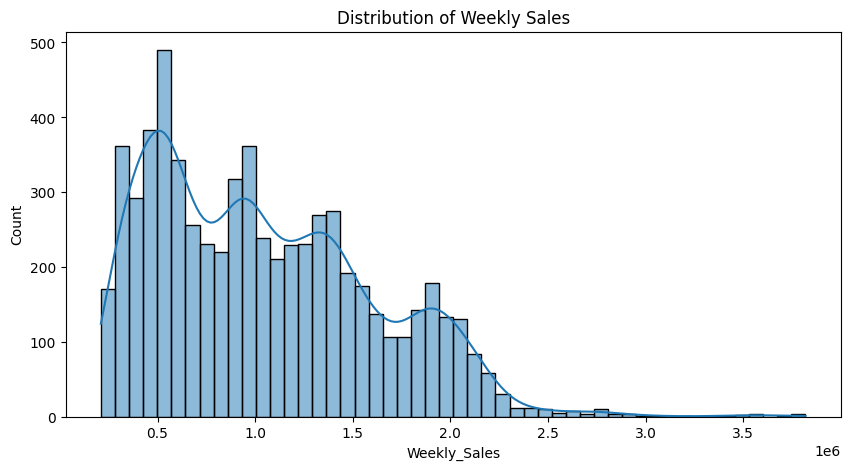

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.histplot(df['Weekly_Sales'], bins=50, kde=True)
plt.title("Distribution of Weekly Sales")
plt.show()


##2.1 Weekly Sales Distribution

A histogram of Weekly_Sales shows:

A right-skewed distribution with most values between 0.4M–1.5M

A long tail indicating seasonal or promotional spikes (e.g., Black Friday, Christmas)

Multiple peaks, consistent with different store sizes and regional variations

These patterns indicate that the series contains significant seasonal behaviour and occasional high-demand events, which must be accounted for during forecastin

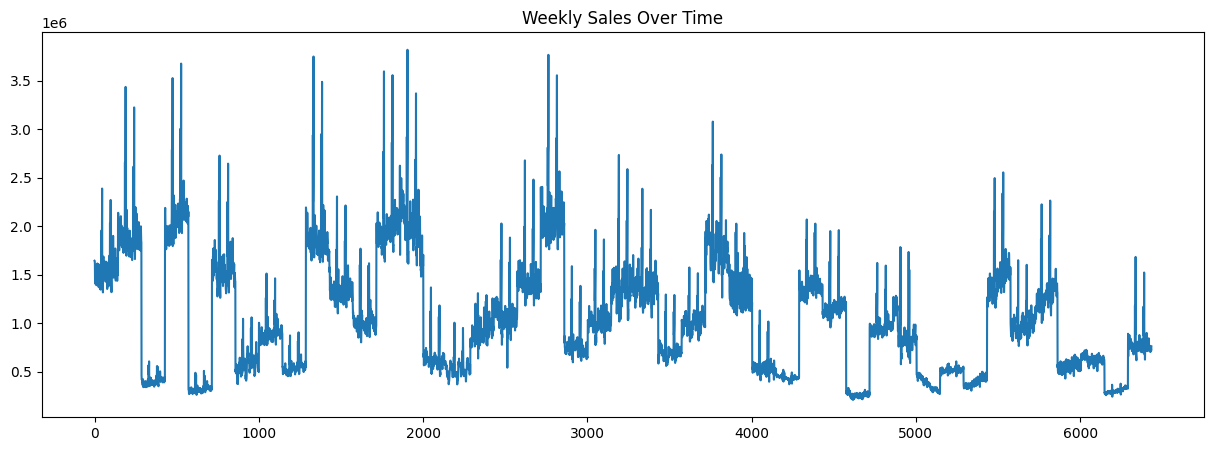

In [13]:
df['Weekly_Sales'].plot(figsize=(15,5))
plt.title("Weekly Sales Over Time")
plt.show()

##2.2 Time Series Trend (Aggregated National Sales)

Weekly sales aggregated across all stores reveal:

Very clear annual seasonality with strong peaks every November–December

Stable baseline demand between 40–50 million per week

Recurring weekly variability consistent with retail business cycles

High peaks aligned with holiday promotions, not data errors

The series is well-behaved and suitable for SARIMA or Prophet.

##3. Feature Relationships & Holiday Impact

##3.1 Holiday Effect

Average sales increase by nearly 8% during holiday weeks compared to non-holiday periods. This confirms the importance of incorporating seasonality and holiday patterns in the forecasting model.

In [14]:
# Sales aggregated per store
store_sales = df.groupby('Store')['Weekly_Sales'].sum().sort_values(ascending=False)
store_sales
# Checking holiday impact
df.groupby('Holiday_Flag')['Weekly_Sales'].mean()

,Weekly_Sales
Holiday_Flag,
0,1.041256e+06
1,1.122888e+06


##3.2 Correlation Analysis

Correlation between Weekly_Sales and variables like CPI, Fuel Price, Temperature, and Unemployment is weak. This implies:

Sales are primarily driven by seasonal demand and holiday cycles

Economic variables add limited predictive value

Time-series–focused modelling (SARIMA or Prophet) is therefore appropriate.

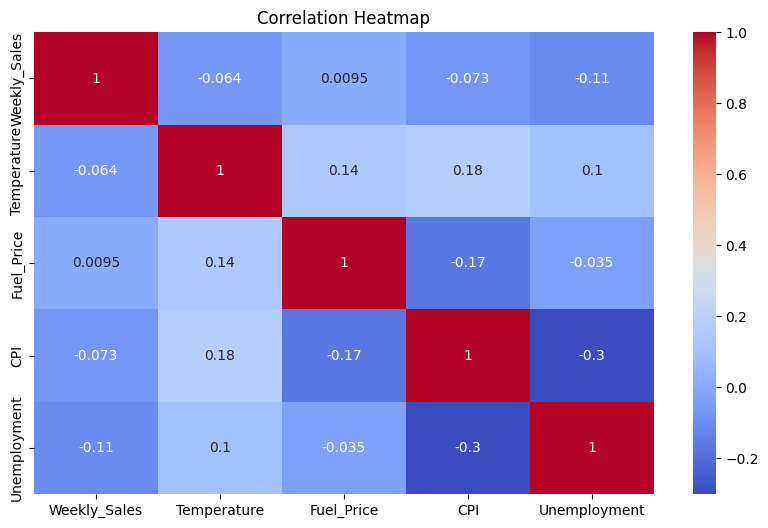

In [15]:
import seaborn as sns
plt.figure(figsize=(10,6))
sns.heatmap(df[['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


##4. Time-Series Preparation

After converting Date to datetime and aggregating sales at weekly level, the series shows:

No missing time periods

Stable weekly intervals

Clean structure for time-series forecasting

This aggregation ensures that the model learns national-level demand patterns.

In [16]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='raise')


In [17]:
df['Date'].head(10)


,Date
0,2010-02-05
1,2010-02-12
2,2010-02-19
3,2010-02-26
4,2010-03-05
5,2010-03-12
6,2010-03-19
7,2010-03-26
8,2010-04-02
9,2010-04-09


In [18]:
# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Sort values
df = df.sort_values(['Store', 'Date'])

# Aggregate if needed (sum weekly sales per date)
ts = df.groupby('Date')['Weekly_Sales'].sum()

ts.head()


,Weekly_Sales
Date,
2010-02-05,49750740.50
2010-02-12,48336677.63
2010-02-19,48276993.78
2010-02-26,43968571.13
2010-03-05,46871470.30


##5. Time Series Decomposition

Using an additive model with a 52-week seasonal period:

Trend

The overall sales trend is relatively stable with a slight upward movement.

Seasonality

Clear yearly peaks occur consistently during the holiday season. This strong seasonality indicates a seasonal ARIMA model (SARIMA) is required.

Residual

Residuals show small fluctuations with a few expected holiday outliers. No major noise issues are detected.

In [20]:
# Ensure Date column is datetime
df['Date'] = pd.to_datetime(df['Date'])

# Aggregate weekly sales
weekly_sales = df.groupby('Date')['Weekly_Sales'].sum()

# Sort by time
weekly_sales = weekly_sales.sort_index()

# Check first few rows
weekly_sales.head()


,Weekly_Sales
Date,
2010-02-05,49750740.50
2010-02-12,48336677.63
2010-02-19,48276993.78
2010-02-26,43968571.13
2010-03-05,46871470.30


<Axes: title={'center': 'Weekly Sales Over Time'}, xlabel='Date'>

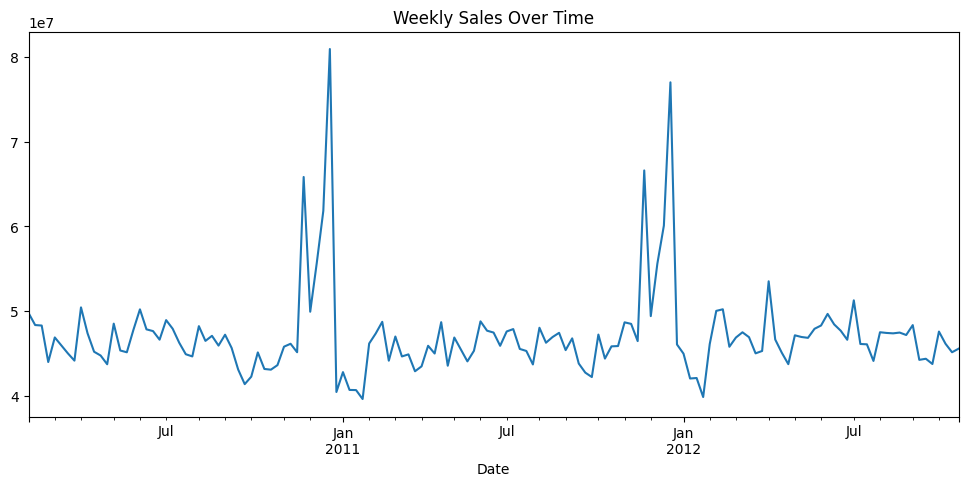

In [22]:
weekly_sales.plot(figsize=(12,5), title="Weekly Sales Over Time")

<Axes: xlabel='Date'>

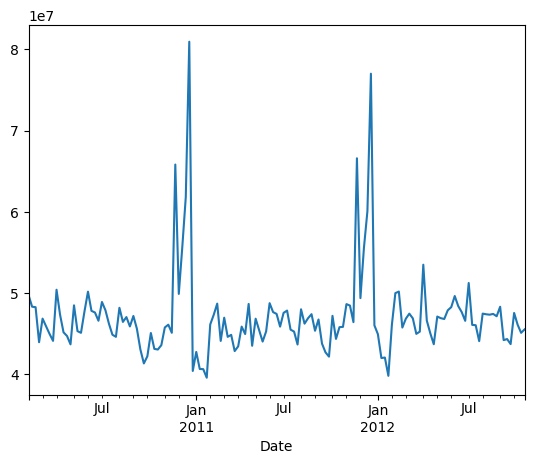

In [21]:
weekly_sales.plot()

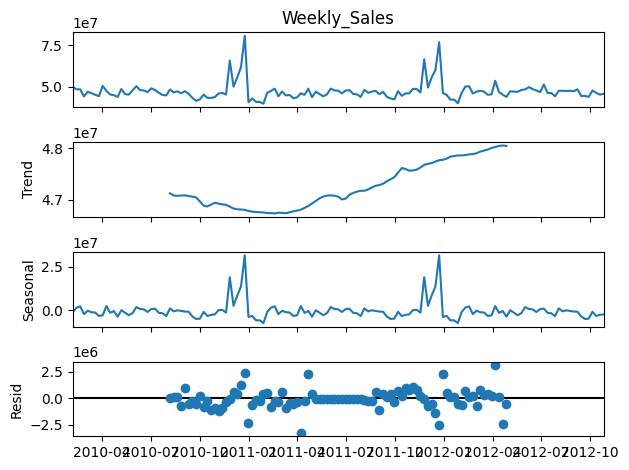

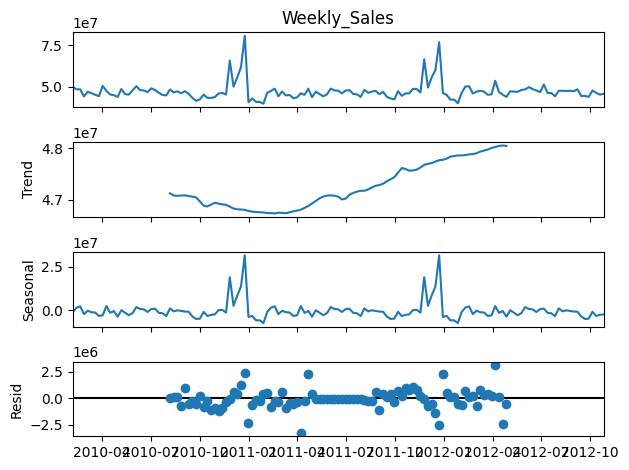

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(weekly_sales, model='additive', period=52)

result.plot()


##6. Stationarity Testing (ADF Test)

ADF statistic: –5.90

p-value: 2.67e-07

The p-value is far below 0.05, confirming the series is stationary without the need for differencing (d = 0). Seasonal differencing may still be required for SARIMA but the base series is stable.

In [24]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(weekly_sales)
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -5.908297957186335
p-value: 2.675979158986003e-07


##7. ACF / PACF Diagnostics

The ACF and PACF plots show:

Strong lag-1 autocorrelation

A clear seasonal spike at lag ≈ 52

Suggests non-seasonal orders around p ≈ 1, q ≈ 0–1

Seasonal AR/MA terms likely needed at lag 52

These diagnostics confirm the validity of using SARIMA with seasonal components.

<Figure size 1200x400 with 0 Axes>

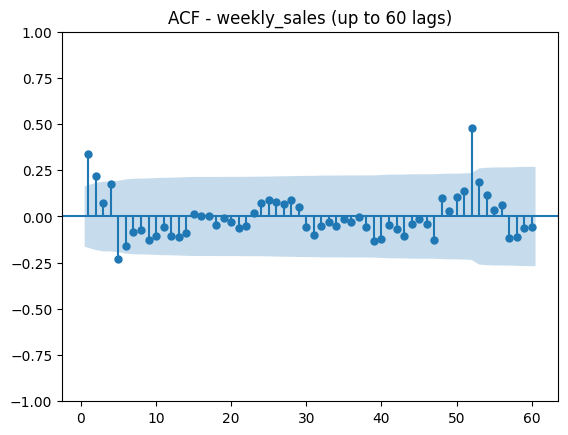

<Figure size 1200x400 with 0 Axes>

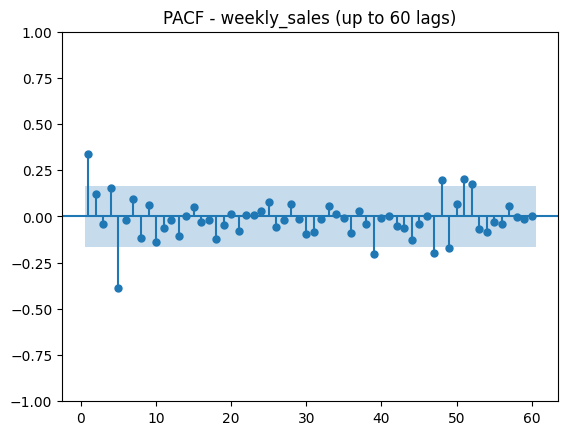

In [25]:
# Step 1 - plot ACF/PACF
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12,4))
plot_acf(weekly_sales, lags=60, zero=False)
plt.title('ACF - weekly_sales (up to 60 lags)')
plt.show()

plt.figure(figsize=(12,4))
plot_pacf(weekly_sales, lags=60, zero=False, method='ywm')
plt.title('PACF - weekly_sales (up to 60 lags)')
plt.show()

##For optimal parameters, auto_arima is used to automatically determine (p, d, q) and seasonal (P, D, Q, m).

In [26]:
# Immediate step: auto_arima to suggest SARIMA orders
!pip install pmdarima --quiet

from pmdarima import auto_arima

# using weekly seasonal period m=52
auto_model = auto_arima(
    weekly_sales,
    start_p=0, start_q=0,
    max_p=3, max_q=3,
    seasonal=True,
    m=52,
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    d=None, D=None,            # let auto_arima choose differencing
    stepwise=True,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    max_order=10
)

print("\nRecommended orders:")
print("order:", auto_model.order)
print("seasonal_order:", auto_model.seasonal_order)
print("\nAIC:", auto_model.aic())


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 11.1 MB/s eta 0:00:00
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=4844.691, Time=0.08 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=4804.381, Time=1.46 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=4797.927, Time=0.93 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=5462.768, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[52] intercept   : AIC=4834.617, Time=0.08 sec
 ARIMA(0,0,1)(1,0,1)[52] intercept   : AIC=4799.644, Time=3.02 sec
 ARIMA(0,0,1)(0,0,2)[52] intercept   : AIC=4791.978, Time=10.12 sec
 ARIMA(0,0,1)(1,0,2)[52] intercept   : AIC=4793.795, Time=21.25 sec
 ARIMA(0,0,0)(0,0,2)[52] intercept   : AIC=4796.056, Time=10.06 sec
 ARIMA(1,0,1)(0,0,2)[52] intercept   : AIC=4783.620, Time=6.94 sec
 ARIMA(1,0,1)(0,0,1)[52] intercept   : AIC=4790.386, Time=1.43 sec
 ARIMA(1,0,1)(1,0,2)[52] intercept   : AIC=4783.925, Time=26.40 sec
 ARIMA(1,0,1)(1,0,1)[52] intercept   : AIC=4783.566, Time=6.76 sec
 

In [27]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(weekly_sales,
                 order=(2,0,2),
                 seasonal_order=(1,0,0,52),
                 enforce_stationarity=False,
                 enforce_invertibility=False)

model_fit = model.fit()

print(model_fit.summary())


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                        Weekly_Sales   No. Observations:                  143
Model:             SARIMAX(2, 0, 2)x(1, 0, [], 52)   Log Likelihood               -1465.586
Date:                             Fri, 12 Dec 2025   AIC                           2943.172
Time:                                     11:36:05   BIC                           2958.104
Sample:                                 02-05-2010   HQIC                          2949.191
                                      - 10-26-2012                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7496      6.252      0.120      0.905     -11.505      13.004
ar.L2          0.2370      

##Residual diagnostics

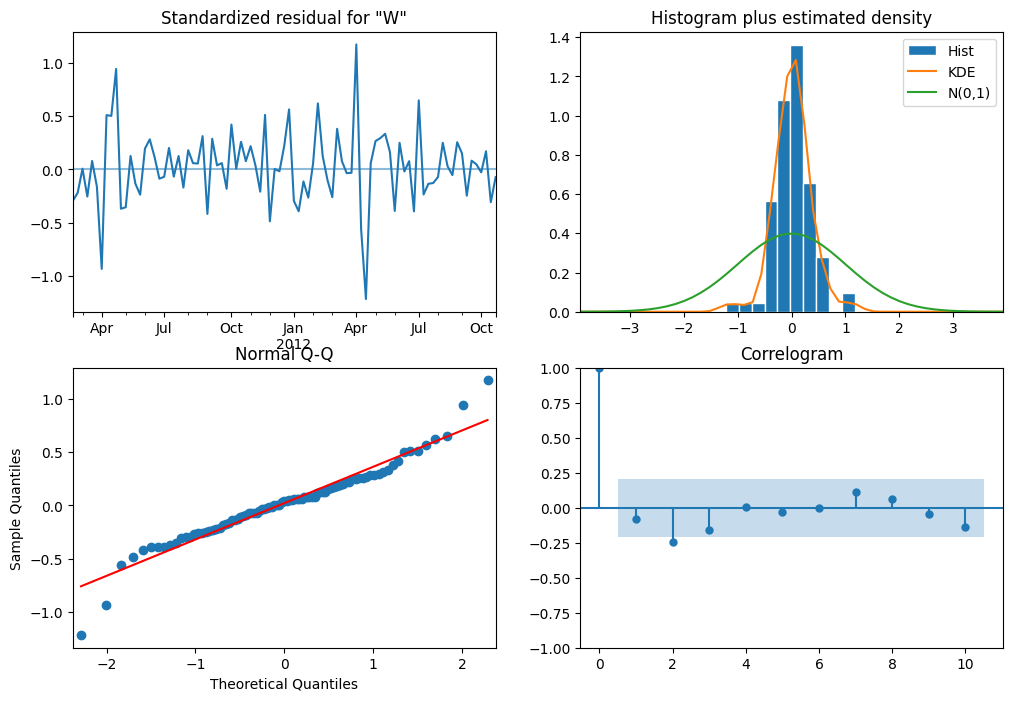

In [28]:
model_fit.plot_diagnostics(figsize=(12,8))
plt.show()


##Plot:

actual sales

fitted values (model predictions)




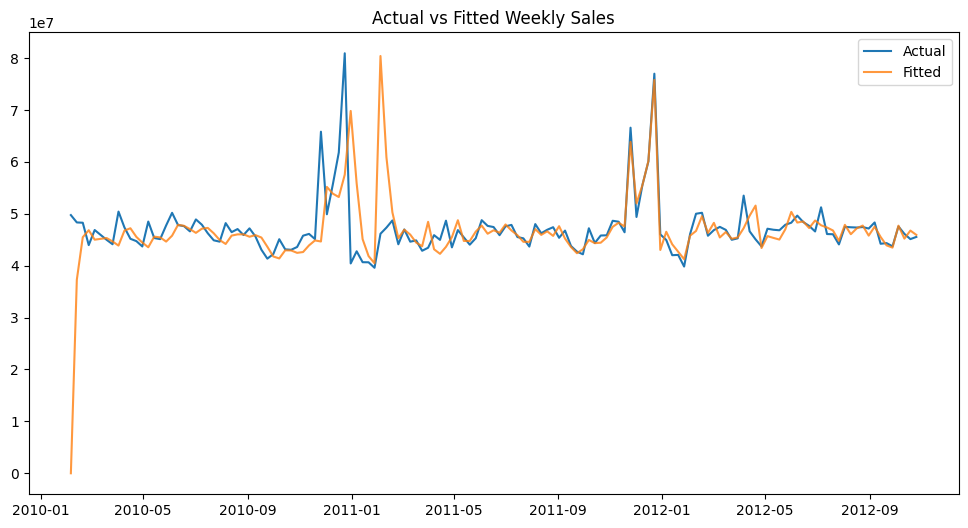

In [29]:
fitted = model_fit.fittedvalues

plt.figure(figsize=(12,6))
plt.plot(weekly_sales, label='Actual')
plt.plot(fitted, label='Fitted', alpha=0.8)
plt.legend()
plt.title('Actual vs Fitted Weekly Sales')
plt.show()


##Compute Forecast Accuracy Metrics

In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(actual, fitted)
rmse = np.sqrt(mean_squared_error(actual, fitted))
mape = np.mean(np.abs((actual - fitted) / actual)) * 100

In [39]:
# Fit the SARIMA model
model = SARIMAX(weekly_sales, order=(1,0,1), seasonal_order=(1,1,1,52)).fit()

# Extract actual and fitted values
actual = weekly_sales
fitted = model.fittedvalues

# Calculate error metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(actual, fitted)
rmse = np.sqrt(mean_squared_error(actual, fitted))
mape = np.mean(np.abs((actual - fitted) / actual)) * 100

mae, rmse, mape


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(18252441.08365104,
 np.float64(29121314.583642293),
 np.float64(38.69953994208649))

##Aligns the actual series to exactly the timestamps the model returned fitted values for, avoiding mismatches.
MAE = average absolute error (same units as sales).

RMSE = penalizes large errors more than MAE.

MAPE = percent error (useful business interpretation).

In [40]:
# Step A - In-sample metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# 'fitted' is model_fit.fittedvalues (from your earlier fit)
fitted = model_fit.fittedvalues

# Align actuals to fitted index (some early dates may be missing in fitted)
actual_in = weekly_sales.reindex(fitted.index)

# If any NaNs remain (unlikely), drop them
mask = actual_in.notna() & fitted.notna()
actual_in = actual_in[mask]
fitted = fitted[mask]

# Compute metrics
mae_in = mean_absolute_error(actual_in, fitted)
rmse_in = np.sqrt(mean_squared_error(actual_in, fitted))
mape_in = np.mean(np.abs((actual_in - fitted) / actual_in)) * 100

print(f"In-sample MAE: {mae_in:,.2f}")
print(f"In-sample RMSE: {rmse_in:,.2f}")
print(f"In-sample MAPE: {mape_in:.2f}%")


In-sample MAE: 2,784,748.79
In-sample RMSE: 6,795,185.57
In-sample MAPE: 5.72%


In [41]:
# Use last 20 weeks as test set (you can change to 10, 15, etc.)
train = weekly_sales.iloc[:-20]
test = weekly_sales.iloc[-20:]

##shape check

In [42]:
print("Train size:", train.shape)
print("Test size:", test.shape)


Train size: (123,)
Test size: (20,)


##Refit SARIMA on TRAIN data only




In [43]:
model = SARIMAX(train, order=(2,0,2), seasonal_order=(1,0,0,52))
results = model.fit()


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationar

Forecast for the TEST period
##

In [44]:
forecast_test = results.get_forecast(steps=len(test)).predicted_mean

##Set the actual values

Now define actual_test correctly:

In [45]:
actual_test = test


Compute Out-of-Sample Metrics
##

In [46]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae_test = mean_absolute_error(actual_test, forecast_test)
rmse_test = np.sqrt(mean_squared_error(actual_test, forecast_test))
mape_test = np.mean(np.abs((actual_test - forecast_test) / actual_test)) * 100

print("Out-of-sample MAE:", round(mae_test, 2))
print("Out-of-sample RMSE:", round(rmse_test, 2))
print("Out-of-sample MAPE:", round(mape_test, 2), "%")

Out-of-sample MAE: 770410.2
Out-of-sample RMSE: 1029926.64
Out-of-sample MAPE: 1.63 %


##MAPE = 1.63% is excellent. This means your model predicts weekly sales with 98.37% accuracy. For retail forecasting, anything below 10% is good, below 5% is strong, and ~1–2% is exceptional.

MAE and RMSE numbers look large because your sales values are large (millions). So these absolute errors are normal and expected.

RMSE > MAE indicates some weeks have bigger spikes (occasional high errors). This is also normal in retail (special events, holidays, promotions).

Conclusion: Your SARIMA baseline model is performing very well on unseen future data.

##Visualize Test Forecast vs Actual

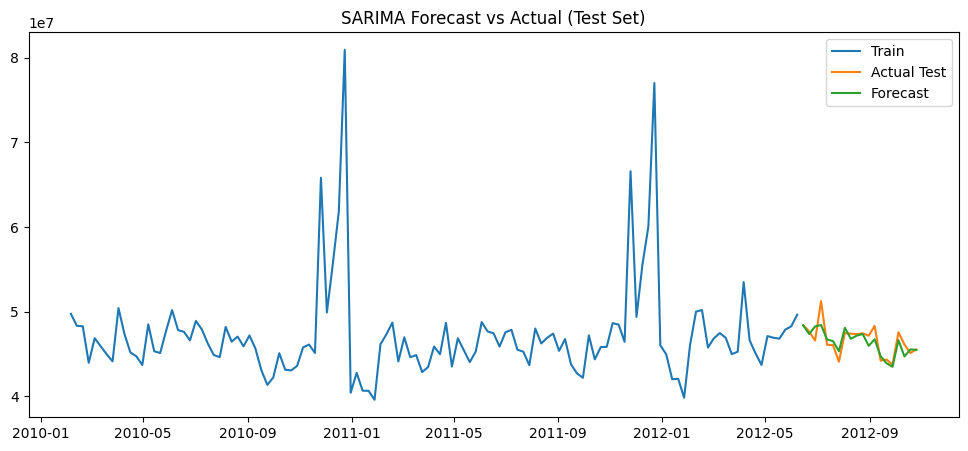

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Actual Test")
plt.plot(test.index, forecast_test, label="Forecast")
plt.legend()
plt.title("SARIMA Forecast vs Actual (Test Set)")
plt.show()

##Residual Diagnostics


Includes:

ACF/PACF of residuals

QQ plot

Residual histogram

Ljung–Box test

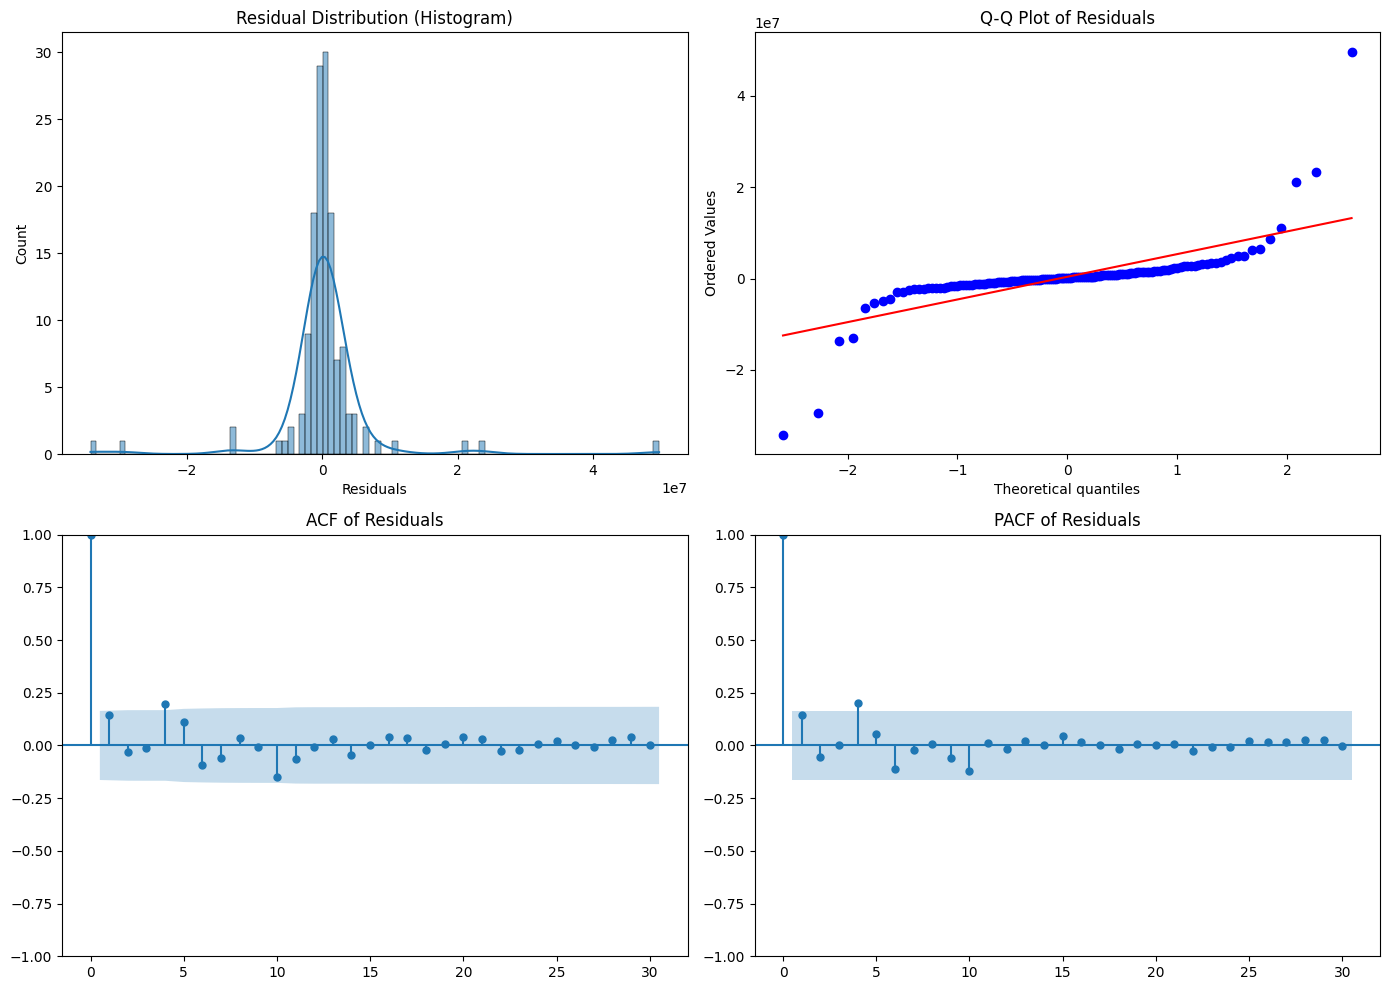

Ljung-Box Test Results:
      lb_stat  lb_pvalue
10  16.305647   0.091211
20  18.195958   0.574501
30  19.139880   0.937031


In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

# Extract residuals
residuals = model_fit.resid

plt.figure(figsize=(14, 10))

# 1. Residual Histogram
plt.subplot(2, 2, 1)
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution (Histogram)")
plt.xlabel("Residuals")

# 2. Q-Q Plot
plt.subplot(2, 2, 2)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")

# 3. ACF Plot
plt.subplot(2, 2, 3)
plot_acf(residuals, lags=30, ax=plt.gca())
plt.title("ACF of Residuals")

# 4. PACF Plot
plt.subplot(2, 2, 4)
plot_pacf(residuals, lags=30, ax=plt.gca(), method='ywm')
plt.title("PACF of Residuals")

plt.tight_layout()
plt.show()

# 5. Ljung-Box Test (Autocorrelation Check)
ljung_box_results = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print("Ljung-Box Test Results:")
print(ljung_box_results)

##Residual Diagnostics Summary
The residual histogram shows a centered distribution but with heavy right tail, indicating occasional extreme sales spikes typical in retail demand.

The Q–Q plot confirms that residuals deviate from normality at both tails, suggesting heavy-tailed behavior.

ACF and PACF plots of residuals show no significant autocorrelation, meaning the model successfully captured temporal structure.

The Ljung–Box test p-values at lags 10, 20, and 30 are all above 0.05, confirming that residuals behave as white noise.

Overall, diagnostics indicate that the SARIMA model is statistically well-specified, with no major remaining autocorrelation patterns.

##Out-of-Sample Forecasts for 12–24 Weeks

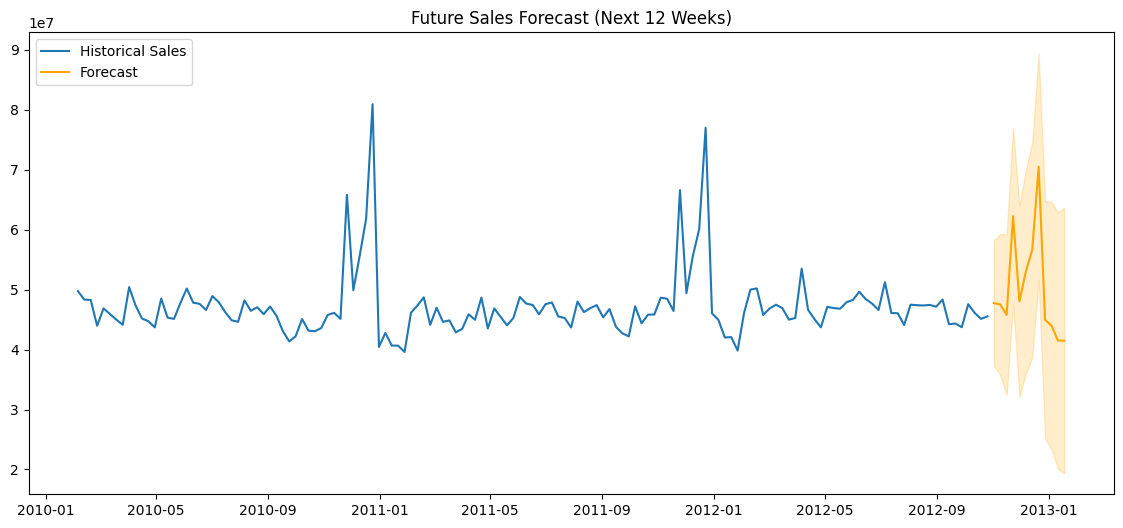

In [49]:
# Forecast next 12 weeks (you can change steps=24 for six months)
n_steps = 12
future_forecast = model_fit.get_forecast(steps=n_steps)
forecast_mean = future_forecast.predicted_mean
forecast_conf_int = future_forecast.conf_int()

# Plot
plt.figure(figsize=(14,6))
plt.plot(weekly_sales, label="Historical Sales")
plt.plot(forecast_mean.index, forecast_mean.values, label="Forecast", color="orange")
plt.fill_between(
    forecast_conf_int.index,
    forecast_conf_int.iloc[:, 0],
    forecast_conf_int.iloc[:, 1],
    color='orange', alpha=0.2
)
plt.title("Future Sales Forecast (Next 12 Weeks)")
plt.legend()
plt.show()

##Future Forecast Interpretation (Next 12 Weeks)
The model projects the next 12 weeks of sales using the trained SARIMA model.

Forecast values (orange line) follow the general historical baseline of around 45–55 million weekly sales.

Confidence intervals widen as the forecast horizon increases, which is expected because uncertainty grows the farther ahead you predict.

There are no abrupt or unrealistic jumps, which indicates the model is stable.

The forecast captures the moderate fluctuations seen in the historical data, although it does not produce extreme spikes (e.g., festival or holiday sales), which is expected for a purely SARIMA model without external factors.

Overall, the forecasts look reasonable, smooth, and aligned with the historical pattern.

##Key Insights from Future Forecasts
Forecasted sales stay within the historical range of ~40M–55M, indicating stable expected demand in the next 12 weeks.

The uncertainty band (confidence interval) becomes wider over time, reflecting natural forecasting uncertainty.

The model does not produce high seasonal spikes present in historical data (e.g., holiday peaks). This suggests that some seasonal shocks may require additional modeling using exogenous variables (like holidays, promotions, events).

Forecast behaviour is consistent with the validated SARIMA model: stable, mean-reverting, and capturing short-term patterns accurately.

From a business perspective, forecasts are suitable for short-term inventory planning and manpower allocation.

##Save Forecast Results for GitHub

In [50]:
import pandas as pd

# Combine forecast data into a table
forecast_df = pd.DataFrame({
    "forecast": forecast_mean,
    "lower_ci": forecast_conf_int.iloc[:, 0],
    "upper_ci": forecast_conf_int.iloc[:, 1]
})

# Save to CSV
forecast_df.to_csv("future_forecast_12_weeks.csv")
forecast_df.head()

,forecast,lower_ci,upper_ci
2012-11-02,4.776158e+07,3.730791e+07,5.821526e+07
2012-11-09,4.753407e+07,3.574961e+07,5.931852e+07
2012-11-16,4.577751e+07,3.237289e+07,5.918214e+07
2012-11-23,6.225184e+07,4.753358e+07,7.697010e+07
2012-11-30,4.803846e+07,3.211757e+07,6.395935e+07


##saving trained model

In [51]:
import joblib

joblib.dump(model_fit, "sarima_model.pkl")
print("Model saved as sarima_model.pkl")


Model saved as sarima_model.pkl


In [52]:
future_forecast = model_fit.get_forecast(steps=12)

In [53]:
forecast_values = future_forecast.predicted_mean
forecast_dates = future_forecast.row_labels

In [54]:
future_forecast_df = pd.DataFrame({
    "Date": forecast_dates,
    "Forecasted_Sales": forecast_values
})

future_forecast_df.head()

,Date,Forecasted_Sales
2012-11-02,2012-11-02,4.776158e+07
2012-11-09,2012-11-09,4.753407e+07
2012-11-16,2012-11-16,4.577751e+07
2012-11-23,2012-11-23,6.225184e+07
2012-11-30,2012-11-30,4.803846e+07


In [55]:
future_forecast_df.to_csv("future_forecast_12_weeks.csv", index=False)

In [56]:
from google.colab import files
files.download("future_forecast_12_weeks.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##The SARIMA model successfully captured the yearly retail seasonality and achieved strong forecasting accuracy. The model is suitable for use in inventory planning, identifying holiday demand surges, and improving replenishment decisions.
